The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

(chapter-harmonics)=
# Harmonics

In this chapter I present several new waveforms; we will look at their spectrums to understand their **harmonic structure**, which is the set of sinusoids they are made up of.

I'll also introduce one of the most important phenomena in digital signal processing: aliasing.
And I'll explain a little more about how the Spectrum class works.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/soln/chap02.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq

# Define PI2 for use in signal definitions
PI2 = 2 * np.pi

(section-triangle-waves)=
## Triangle Waves

A sinusoid contains only one frequency component, so its spectrum has only one peak.
More complicated waveforms, like the violin recording, yield DFTs with many peaks.
In this section we investigate the relationship between waveforms and their spectrums.

I'll start with a triangle waveform, which is like a straight-line version of a sinusoid.

To generate a triangle wave, you can use `thinkdsp.TriangleSignal`:

In [4]:
from thinkdsp import Sinusoid

class TriangleSignal(Sinusoid):

    def evaluate(self, ts):
        cycles = self.freq * ts + self.offset / PI2
        frac, _ = np.modf(cycles)
        ys = np.abs(frac - 0.5)
        ys = normalize(unbias(ys), self.amp)
        return ys

`TriangleSignal` inherits `__init__` from `Sinusoid`, so it takes the same arguments: `freq`, `amp`, and `offset`.

The only difference is `evaluate`.
As we saw before, `ts` is the sequence of sample times where we want to evaluate the signal.

There are many ways to generate a triangle wave.
The details are not important, but here's how `evaluate` works:

1.  `cycles` is the number of cycles since the start time.
`np.modf` splits the number of cycles into the fraction part, stored in `frac`, and the integer part, which is ignored [^1].

2.  `frac` is a sequence that ramps from 0 to 1 with the given frequency.
Subtracting 0.5 yields values between -0.5 and 0.5. Taking the absolute value yields a waveform that zig-zags between 0.5 and 0.

3.  `unbias` shifts the waveform down so it is centered at 0; then `normalize` scales it to the given amplitude, `amp`.

Here's what it looks like.

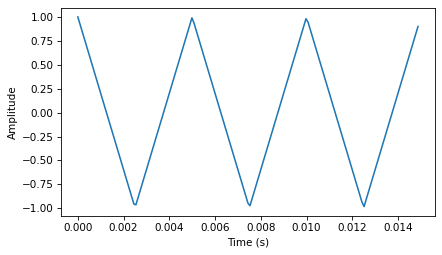

In [5]:
import thinkdsp

signal = thinkdsp.TriangleSignal(200)
signal.plot()
decorate_time()

Next we can use the Signal to make a Wave, and use the Wave to make a Spectrum:

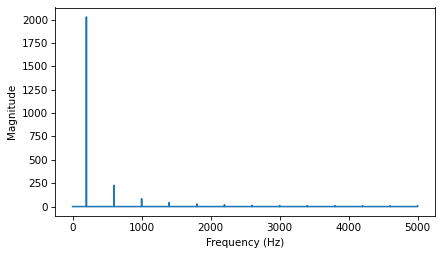

In [6]:
wave = signal.make_wave(duration=0.5, framerate=10000)
spectrum = wave.make_spectrum()
spectrum.plot()
decorate_freq()

As expected, the highest peak is at the fundamental frequency, 200 Hz, and there are additional peaks at harmonic frequencies, which are integer multiples of 200.

But one surprise is that there are no peaks at the even multiples: 400, 800, etc.
The harmonics of a triangle wave are all odd multiples of the fundamental frequency, in this example 600, 1000, 1400, etc.

Another feature of this spectrum is the relationship between the amplitude and frequency of the harmonics.
Their amplitude drops off in proportion to frequency squared.
For example the frequency ratio of the first two harmonics (200 and 600 Hz) is 3, and the amplitude ratio is approximately 9. The frequency ratio of the next two harmonics (600 and 1000 Hz) is 1.7, and the amplitude ratio is approximately $1.7^2 = 2.9$. This relationship is called the **harmonic structure**.


(section-square-waves)=
## Square Waves

`thinkdsp` also provides `SquareSignal`, which represents a square signal.
Here's the class definition:

In [7]:
class SquareSignal(Sinusoid):

    def evaluate(self, ts):
        cycles = self.freq * ts + self.offset / PI2
        frac, _ = np.modf(cycles)
        ys = self.amp * np.sign(unbias(frac))
        return ys

Like `TriangleSignal`, `SquareSignal` inherits `__init__` from `Sinusoid`, so it takes the same parameters.

And the `evaluate` method is similar.
Again, `cycles` is the number of cycles since the start time, and `frac` is the fractional part, which ramps from 0 to 1 each period.

`unbias` shifts `frac` so it ramps from -0.5 to 0.5, then `np.sign` maps the negative values to -1 and the positive values to 1. Multiplying by `amp` yields a square wave that jumps between `-amp` and `amp`.

The following figure shows three periods of a square wave with frequency 100 Hz.

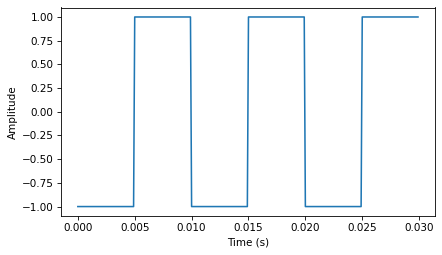

In [8]:
from thinkdsp import SquareSignal

signal = SquareSignal(100)
duration = signal.period*3
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate_time()

In [9]:
wave = signal.make_wave(duration=0.5, framerate=10000)
wave.apodize()
wave.make_audio()

And here is its spectrum.

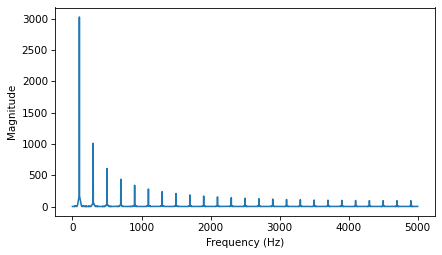

In [10]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate_freq()

Like a triangle wave, the square wave contains only odd harmonics, which is why there are peaks at 300, 500, and 700 Hz, etc.
But the amplitude of the harmonics drops off more slowly.
Specifically, amplitude drops in proportion to frequency (not frequency squared).

The exercises at the end of this chapter give you a chance to explore other waveforms and other harmonic structures.


(section-aliasing)=
## Aliasing

I have a confession.
I chose the examples in the previous section carefully to avoid showing you something confusing.
But now it's time to get confused.

The following figure shows the spectrum of a triangle wave at 1100 Hz, sampled at 10,000 frames per second.
Again, the view on the right is scaled to show the harmonics.

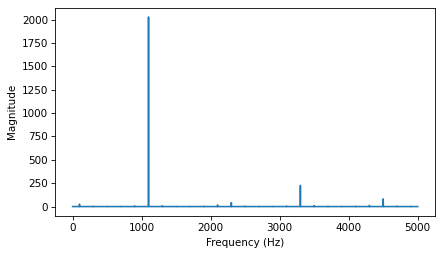

In [11]:
signal = thinkdsp.TriangleSignal(1100)
segment = signal.make_wave(duration=0.5, framerate=10000)
spectrum = segment.make_spectrum()
spectrum.plot()
decorate_freq()

The harmonics of this wave should be at 3300, 5500, 7700, and 9900 Hz. In the figure, there are peaks at 1100 and 3300 Hz, as expected, but the third peak is at 4500, not 5500 Hz. The fourth peak is at 2300, not 7700 Hz. And if you look closely, the peak that should be at 9900 is actually at 100 Hz. What's going on?

The problem is that when you evaluate the signal at discrete points in time, you lose information about what happened between samples.
For low frequency components, that's not a problem, because you have lots of samples per period.

But if you sample a signal at 5000 Hz with 10,000 frames per second, you only have two samples per period.
That turns out to be enough, just barely, but if the frequency is higher, it's not.

To see why, let's generate cosine signals at 4500 and 5500 Hz, and sample them at 10,000 frames per second:

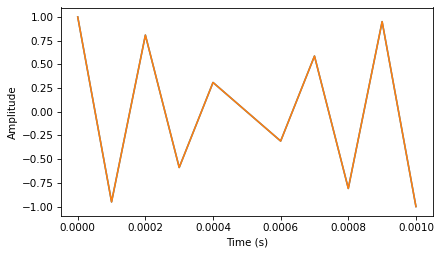

In [12]:
framerate = 10000

signal = thinkdsp.CosSignal(4500)
duration = signal.period*5
segment = signal.make_wave(duration, framerate=framerate)
segment.plot()

signal = thinkdsp.CosSignal(5500)
segment = signal.make_wave(duration, framerate=framerate)
segment.plot()
decorate_time()

I plotted the Signals with thin gray lines and the samples using vertical lines, to make it easier to compare the two Waves.
The problem should be clear: even though the Signals are different, the Waves are identical!

When we sample a 5500 Hz signal at 10,000 frames per second, the result is indistinguishable from a 4500 Hz signal.
For the same reason, a 7700 Hz signal is indistinguishable from 2300 Hz, and a 9900 Hz is indistinguishable from 100 Hz.

This effect is called **aliasing** because when the high frequency signal is sampled, it appears to be a low frequency signal.

In this example, the highest frequency we can measure is 5000 Hz, which is half the sampling rate.
Frequencies above 5000 Hz are folded back below 5000 Hz, which is why this threshold is sometimes called the "folding frequency".
It is sometimes also called the **Nyquist frequency**.
See <http://en.wikipedia.org/wiki/Nyquist_frequency>.

The folding pattern continues if the aliased frequency goes below zero.
For example, the 5th harmonic of the 1100 Hz triangle wave is at 12,100 Hz. Folded at 5000 Hz, it would appear at -2100 Hz, but it gets folded again at 0 Hz, back to 2100 Hz. In fact, you can see a small peak at 2100 Hz and the next one at 4300 Hz.


(section-computing-the-spectrum)=
## Computing the Spectrum

We have seen the Wave method `make_spectrum` several times.
Here is the implementation (leaving out some details we'll get to later):

In [13]:
def make_spectrum(self):
    n = len(self.ys)
    d = 1 / self.framerate

    hs = np.fft.rfft(self.ys)
    fs = np.fft.rfftfreq(n, d)

    return Spectrum(hs, fs, self.framerate)

The parameter `self` is a Wave object.
`n` is the number of samples in the wave, and `d` is the inverse of the frame rate, which is the time between samples.

`np.fft` is the NumPy module that provides functions related to the **Fast Fourier Transform** (FFT), which is an efficient algorithm that computes the Discrete Fourier Transform (DFT).

`make_spectrum` uses `rfft`, which stands for "real FFT", because the Wave contains real values, not complex.
Later we'll see the full FFT, which can handle complex signals.
The result of `rfft`, which I call `hs`, is a NumPy array of complex numbers that represents the amplitude and phase offset of each frequency component in the wave.

The result of `rfftfreq`, which I call `fs`, is an array that contains frequencies corresponding to the `hs`.

To understand the values in `hs`, consider these two ways to think about complex numbers:

-   A complex number is the sum of a real part and an imaginary part, often written $x + iy$, where $i$ is the imaginary unit, $\sqrt{-1}$.
You can think of $x$ and $y$ as Cartesian coordinates.

-   A complex number is also the product of a magnitude and a complex exponential, $A e^{i \phi}$, where $A$ is the **magnitude** and $\phi$ is the **angle** in radians, also called the "argument".
You can think of $A$ and $\phi$ as polar coordinates.

Each value in `hs` corresponds to a frequency component: its magnitude is proportional to the amplitude of the corresponding component; its angle is the phase offset.

The Spectrum class provides two read-only properties, `amps` and `angles`, which return NumPy arrays representing the magnitudes and angles of the `hs`.
When we plot a Spectrum object, we usually plot `amps` versus `fs`.
Sometimes it is also useful to plot `angles` versus `fs`.

Although it might be tempting to look at the real and imaginary parts of `hs`, you will almost never need to. I encourage you to think of the DFT as a vector of amplitudes and phase offsets that happen to be encoded in the form of complex numbers.

To modify a Spectrum, you can access the `hs` directly.
For example:

In [14]:
spectrum.hs *= 2
spectrum.hs[spectrum.fs > 2000] = 0

The first line multiples the elements of `hs` by 2, which doubles the amplitudes of all components.
The second line sets to 0 only the elements of `hs` where the corresponding frequency exceeds some cutoff frequency.

But Spectrum also provides methods to perform these operations:

In [15]:
spectrum.scale(2)
spectrum.low_pass(2000)

You can read the documentation of these methods and others at <http://greenteapress.com/thinkdsp.html>.

At this point you should have a better idea of how the Signal, Wave, and Spectrum classes work, but I have not explained how the Fast Fourier Transform works.
That will take a few more chapters.


(section-amplitude-and-phase)=
## Amplitude and Phase

To explore how amplitude and phase work, let's make a sawtooth wave:

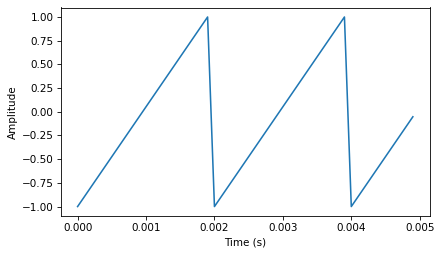

In [16]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(500)
wave = signal.make_wave(duration=1, framerate=10000)
segment = wave.segment(duration=0.005)
segment.plot()
decorate_time()

Here's what it sounds like:

In [17]:
wave.make_audio()

Extract the wave array and compute the real FFT (which is just an FFT optimized for real inputs):

In [18]:
hs = np.fft.rfft(wave.ys)
hs

array([ 5.115908e-13+0.000000e+00j,  2.197007e-13-1.345593e-13j,
       -2.095487e-13-6.746035e-14j, ...,  4.196062e-13+3.460010e-14j,
       -5.632808e-13+5.749150e-14j, -5.263158e+02+0.000000e+00j])

Compute the frequencies that match up with the elements of the FFT:

In [19]:
n = len(wave.ys)                 # number of samples
d = 1 / wave.framerate           # time between samples
fs = np.fft.rfftfreq(n, d)
fs

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.998e+03, 4.999e+03,
       5.000e+03])

Plot the magnitudes vs the frequencies:

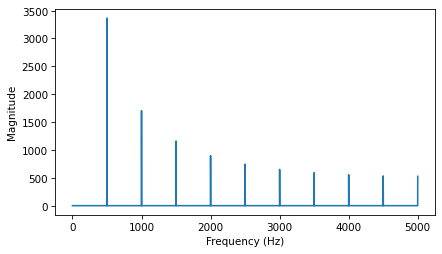

In [20]:
magnitude = np.absolute(hs)
plt.plot(fs, magnitude)
decorate_freq()

Plot the phases vs the frequencies:

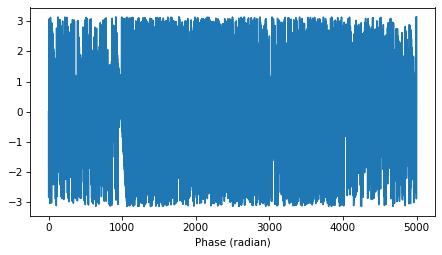

In [21]:
angle = np.angle(hs)
plt.plot(fs, angle)
decorate(xlabel='Phase (radian)')

(section-what-does-phase-sound-like)=
## What Does Phase Sound Like?

Let's see what happens when we shuffle the phases:

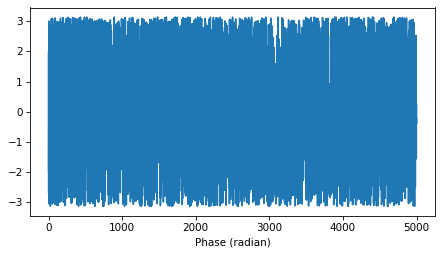

In [22]:
import random

random.shuffle(angle)
plt.plot(fs, angle)
decorate(xlabel='Phase (radian)')

Put the shuffled phases back into the spectrum. Each element in `hs` is a complex number with magnitude $A$ and phase $\phi$, with which we can compute $A e^{i \phi}$:

In [23]:
i = complex(0, 1)
spectrum = wave.make_spectrum()
spectrum.hs = magnitude * np.exp(i * angle)

Convert the spectrum back to a wave (which uses irfft):

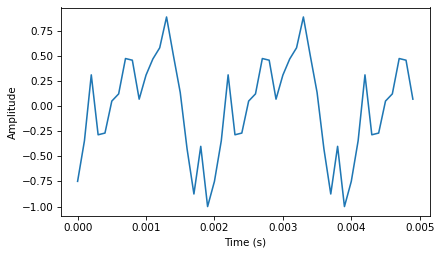

In [24]:
wave2 = spectrum.make_wave()
wave2.normalize()
segment = wave2.segment(duration=0.005)
segment.plot()
decorate_time()

Here's what it sounds like with the shuffled phases:

In [25]:
wave2.make_audio()

For comparison, here's the original wave again:

In [26]:
wave.make_audio()

Although the two signals have different waveforms, they have the same frequency components with the same amplitudes. They differ only in phase.


(section-aliasing-interaction)=
## Aliasing Interaction

The following interaction explores the effect of aliasing on the harmonics of a sawtooth signal:

In [27]:
def view_harmonics(freq, framerate):
    """Plot the spectrum of a sawtooth signal.
    
    freq: frequency in Hz
    framerate: in frames/second
    """
    signal = SawtoothSignal(freq)
    wave = signal.make_wave(duration=0.5, framerate=framerate)
    spectrum = wave.make_spectrum()
    spectrum.plot(color='C0')
    decorate_freq()
    display(wave.make_audio())

In [28]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider1 = widgets.FloatSlider(min=100, max=10000, value=100, step=100)
slider2 = widgets.FloatSlider(min=5000, max=40000, value=10000, step=1000)
interact(view_harmonics, freq=slider1, framerate=slider2);

interactive(children=(FloatSlider(value=100.0, description='freq', max=10000.0, min=100.0, step=100.0), FloatS…

## Exercises

### Exercise 2.1

A sawtooth signal has a waveform that ramps up linearly from -1 to 1, then drops to -1 and repeats.
See http://en.wikipedia.org/wiki/Sawtooth_wave

Write a class called `SawtoothSignal` that extends `Signal` and provides `evaluate` to evaluate a sawtooth signal.

Compute the spectrum of a sawtooth wave.
How does the harmonic structure compare to triangle and square waves? 


My solution is basically a simplified version of TriangleSignal.

In [29]:
from thinkdsp import Sinusoid
from thinkdsp import normalize, unbias
import numpy as np

class SawtoothSignal(Sinusoid):
    """Represents a sawtooth signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        cycles = self.freq * ts + self.offset / np.pi / 2
        frac, _ = np.modf(cycles)
        ys = normalize(unbias(frac), self.amp)
        return ys

Here's what it sounds like:

In [30]:
sawtooth = SawtoothSignal().make_wave(duration=0.5, framerate=40000)
sawtooth.make_audio()

And here's what the spectrum looks like:

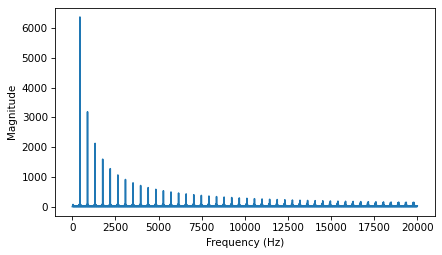

In [31]:
sawtooth.make_spectrum().plot()
decorate_freq()

Compared to a square wave, the sawtooth drops off similarly, but it includes both even and odd harmonics.
Notice that I had to cut the amplitude of the square wave to make them comparable.

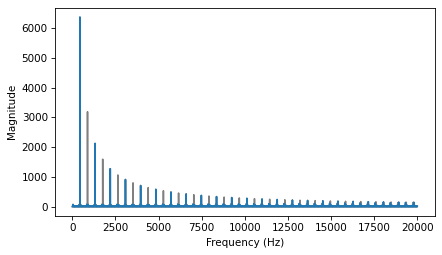

In [32]:
from thinkdsp import SquareSignal

sawtooth.make_spectrum().plot(color='gray')
square = SquareSignal(amp=0.5).make_wave(duration=0.5, framerate=40000)
square.make_spectrum().plot()
decorate_freq()

Compared to a triangle wave, the sawtooth doesn't drop off as fast.

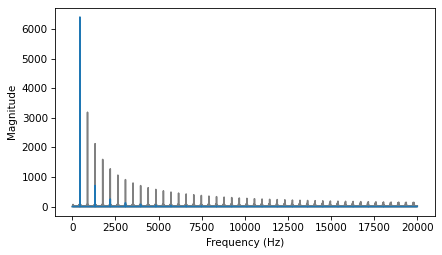

In [33]:
from thinkdsp import TriangleSignal

sawtooth.make_spectrum().plot(color='gray')
triangle = TriangleSignal(amp=0.79).make_wave(duration=0.5, framerate=40000)
triangle.make_spectrum().plot()
decorate_freq()

Specifically, the harmonics of the triangle wave drop off in proportion to $1/f^2$, while the sawtooth drops off like $1/f$.

### Exercise 2.2

Make a square signal at 1500 Hz and make a wave that samples it at 10000 frames per second.
If you plot the spectrum, you can see that most of the harmonics are aliased.
When you listen to the wave, can you hear the aliased harmonics? 


Here's the square wave:

In [34]:
square = SquareSignal(1500).make_wave(duration=0.5, framerate=10000)

Here's what the spectrum looks like:

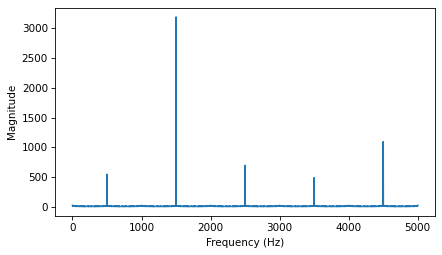

In [35]:
square.make_spectrum().plot()
decorate_freq()

You can see the fundamental at 1500 Hz and the first harmonic at 4500 Hz, but the second harmonic, which should be at 7500 Hz, is aliased to 2500 Hz.

The third harmonic, which should be at 10500 Hz, would get aliased to -500 Hz, but that gets aliased again to 500 Hz.

And the 4th harmonic, which should be at 13500 Hz, ends up at 3500 Hz.

The 5th harmonic, which should be at 16500 Hz, ends up at 1500 Hz, so it contributes to the fundamental.

The remaining harmonics overlap with the ones we've already seen.

When you listen to the wave, the fundamental pitch you perceive is the alias at 500 Hz.

In [36]:
square.make_audio()

If you compare it to this 500 Hz sine wave, you might hear what I mean.

In [37]:
from thinkdsp import SinSignal

SinSignal(500).make_wave(duration=0.5, framerate=10000).make_audio()

### Exercise 2.3

If you have a spectrum object, `spectrum`, and print the first few values of `spectrum.fs`, you'll see that the frequencies start at zero.
So `spectrum.hs[0]` is the magnitude of the component with frequency 0. But what does that mean?

Try this experiment:

1.    Make a triangle signal with frequency 440 and make a Wave with duration 0.01 seconds.
Plot the waveform.
2.    Make a Spectrum object and print `spectrum.hs[0]`.
What is the amplitude and phase of this component? 3.    Set `spectrum.hs[0] = 100`.
Make a Wave from the modified Spectrum and plot it. What effect does this operation have on the waveform?


Here's the triangle wave:

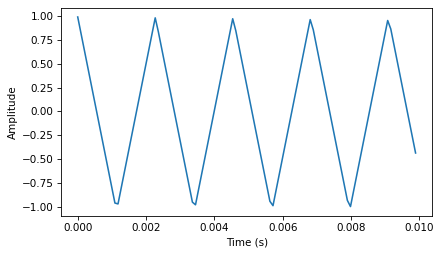

In [38]:
triangle = TriangleSignal().make_wave(duration=0.01)
triangle.plot()
decorate_time()

The first element of the spectrum is a complex number close to zero.

In [39]:
spectrum = triangle.make_spectrum()
spectrum.hs[0]

(1.0436096431476471e-14+0j)

If we add to the zero-frequency component, it has the effect of adding a vertical offset to the wave.

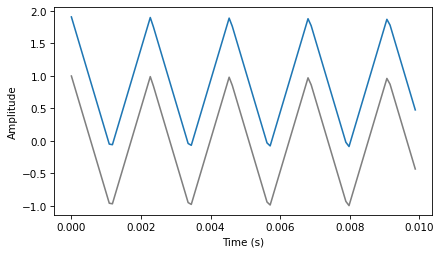

In [40]:
spectrum.hs[0] = 100
triangle.plot(color='gray')
spectrum.make_wave().plot()
decorate_time()

The zero-frequency component is the total of all the values in the signal, as we'll see when we get into the details of the DFT.
If the signal is unbiased, the zero-frequency component is 0.  In the context of electrical signals, the zero-frequency term is called the DC offset; that is, a direct current offset added to an AC signal.

### Exercise 2.4

Write a function that takes a Spectrum as a parameter and modifies it by dividing each element of hs by the corresponding frequency from fs. Test your function using one of the WAV files in the repository or any Wave object.

1. Compute the Spectrum and plot it. 2. Modify the Spectrum using your function and plot it again.
3. Make a Wave from the modified Spectrum and listen to it. What effect does this operation have on the signal?


Here's my version of the function:

In [41]:
def filter_spectrum(spectrum):
    """Divides the spectrum through by the fs.
    
    spectrum: Spectrum object
    """
    # avoid division by 0
    spectrum.hs[1:] /= spectrum.fs[1:]
    spectrum.hs[0] = 0

Here's a triangle wave:

In [42]:
wave = TriangleSignal(freq=440).make_wave(duration=0.5)
wave.make_audio()

Here's what the before and after look like.
I scaled the after picture to make it visible on the same scale.

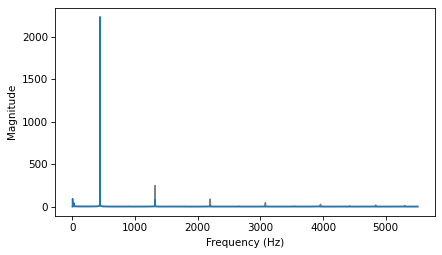

In [43]:
spectrum = wave.make_spectrum()
spectrum.plot(high=10000, color='gray')
filter_spectrum(spectrum)
spectrum.scale(440)
spectrum.plot(high=10000)
decorate_freq()

The filter clobbers the harmonics, so it acts like a low pass filter.

Here's what it sounds like:

In [44]:
filtered = spectrum.make_wave()
filtered.make_audio()

The triangle wave now sounds almost like a sine wave.

### Exercise 2.5

The triangle and square waves have odd harmonics only; the sawtooth wave has both even and odd harmonics.
The harmonics of the square and sawtooth waves drop off in proportion to $1/f$; the harmonics of the triangle wave drop off like $1/f^2$.
Can you find a waveform that has even and odd harmonics that drop off like $1/f^2$?

Hint: There are two ways you could approach this: you could construct the signal you want by adding up sinusoids, or you could start with a signal that is similar to what you want and modify it.


One option is to start with a sawtooth wave, which has all of the harmonics we need:

In [45]:
freq = 500
signal = SawtoothSignal(freq=freq)
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

Here's what the spectrum looks like.
The harmonics drop off like $1/f$.

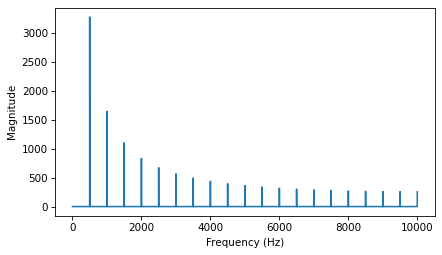

In [46]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate_freq()

If we apply the filter we wrote in the previous exercise, we can make the harmonics drop off like $1/f^2$.

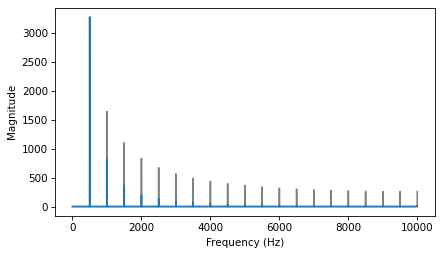

In [47]:
spectrum.plot(color='gray')
filter_spectrum(spectrum)
spectrum.scale(freq)
spectrum.plot()
decorate_freq()

Here's what it sounds like:

In [48]:
wave = spectrum.make_wave()
wave.make_audio()

And here's what the waveform looks like.

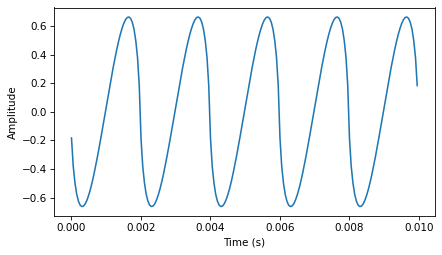

In [49]:
wave.segment(duration=0.01).plot()
decorate_time()

It's an interesting shape, but not easy to see what its functional form is.

Another approach is to add up a series of cosine signals with the right frequencies and amplitudes.

In [50]:
from thinkdsp import CosSignal

freqs = np.arange(500, 9500, 500)
amps = 1 / freqs**2
signal = sum(CosSignal(freq, amp) for freq, amp in zip(freqs, amps))
signal

Here's what the spectrum looks like:

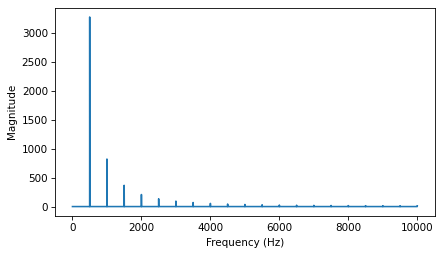

In [51]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate_freq()

Here's what it sounds like:

In [52]:
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

And here's what the waveform looks like.

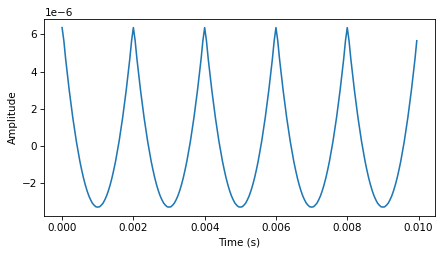

In [53]:
wave.segment(duration=0.01).plot()
decorate_time()

If you think those like parabolas, you might be right.
`thinkdsp` provides `ParabolicSignal`, which computes parabolic waveforms.

In [54]:
from thinkdsp import ParabolicSignal

wave = ParabolicSignal(freq=500).make_wave(duration=0.5, framerate=20000)
wave.make_audio()

Here's what the waveform looks like:

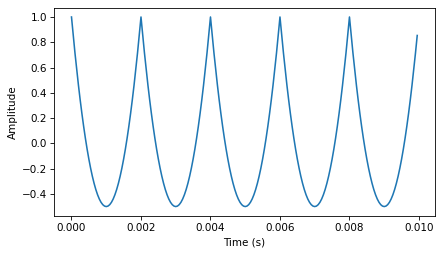

In [55]:
wave.segment(duration=0.01).plot()
decorate_time()

A parabolic signal has even and odd harmonics which drop off like $1/f^2$:

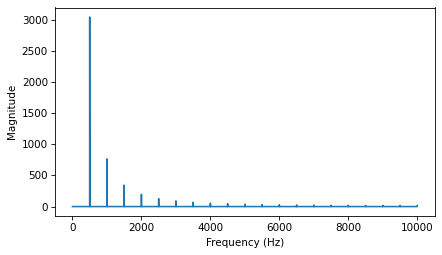

In [56]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate_freq()

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)